In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install catboost
!pip install lightgbm
!pip install cmake
!pip install seaborn
!pip install bayesian-optimization
!pip install imblearn

In [ ]:
# from catboost import CatBoostClassifier 
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

sns.set()

%matplotlib inline

In [ ]:
def reduce_mem_usage(df):
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in tqdm(df.columns):
        if df[col].dtype != object:  # Exclude strings

            # make variables for Int, max and min
            IsInt = False
            col_max_value = df[col].max()
            col_min_value = df[col].min()

            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(col_min_value - 1, inplace=True)

            # test if column can be converted to an integer
            col_as_int = df[col].fillna(0).astype(np.int64)
            diff = (df[col] - col_as_int)
            diff = diff.sum()
            if np.abs(diff) < 0.01:
                IsInt = True

            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if col_min_value >= 0:
                    if col_max_value < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif col_max_value < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif col_max_value < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if col_min_value > np.iinfo(np.int8).min and col_max_value < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif col_min_value > np.iinfo(np.int16).min and col_max_value < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif col_min_value > np.iinfo(np.int32).min and col_max_value < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif col_min_value > np.iinfo(np.int64).min and col_max_value < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    

            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)

    return df, NAlist

In [ ]:
train_transaction = pd.read_csv('/content/drive/MyDrive/kaggle data/train_transaction.csv')
train_identity = pd.read_csv('/content/drive/MyDrive/kaggle data/train_identity.csv')
test_transaction = pd.read_csv('/content/drive/MyDrive/kaggle data/test_transaction.csv')
test_identity = pd.read_csv('/content/drive/MyDrive/kaggle data/test_identity.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/kaggle data/sample_submission.csv')

df_train = train_transaction.merge(train_identity, how='left', on='TransactionID')
del train_transaction, train_identity
df_train, df_train_NAlist = reduce_mem_usage(df_train)

df_test = test_transaction.merge(test_identity, how='left', on='TransactionID')
del test_transaction, test_identity
df_test, df_test_NAlist = reduce_mem_usage(df_test)

100%|████████████████████████████████████████████████████████████████████████████████| 433/433 [00:25<00:00, 16.99it/s]


В данных есть пропуски:

In [ ]:
print('Missing data in train: {:.5f}%'.format(df_train.isnull().sum().sum() / (df_train.shape[0] * df_train.shape[1]) * 100))
print('Missing data in test: {:.5f}%'.format(df_test.isnull().sum().sum() / (df_test.shape[0] * df_test.shape[1]) * 100))

Missing data in train: 4.47002%
Missing data in test: 4.33051%


Заполним пропуски в столбцах, где значения выражаются числами - `-1`, а где строками - `'unseen_category'`.

In [ ]:
for col in df_train.columns.drop('isFraud'):
    if df_train[col].dtype == 'O':
        df_train[col] = df_train[col].fillna('unseen_category')
        df_test[col] = df_test[col].fillna('unseen_category')
    else:
        df_train[col] = df_train[col].fillna(-1)
        df_test[col] = df_test[col].fillna(-1)

print('Missing data in train: {:.5f}%'.format(df_train.isnull().sum().sum() / (df_train.shape[0] * df_train.shape[1]) * 100))
print('Missing data in test: {:.5f}%'.format(df_test.isnull().sum().sum() / (df_test.shape[0] * df_test.shape[1]) * 100))

Missing data in train: 0.00000%
Missing data in test: 0.00000%


In [ ]:
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417559 entries, 0 to 417558
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float32(80), int16(7), int8(9), object(31), uint16(40), uint32(3), uint8(264)
memory usage: 380.3+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 172981 entries, 0 to 172980
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: float32(78), int16(6), int8(9), object(31), uint16(57), uint32(3), uint8(249)
memory usage: 159.0+ MB


(None, None)

Закодируем категориальные признаки с помощью [`LabelEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) и сконвертируем их в [`category`](https://pandas.pydata.org/pandas-docs/version/0.23.4/categorical.html).

In [ ]:
for col in tqdm(df_train.columns.drop('isFraud')):
    if df_train[col].dtype == 'O':
        le = LabelEncoder()
        le.fit(list(df_train[col]) + list(df_test[col]))
        df_train[col] = le.transform(df_train[col])
        df_test[col] = le.transform(df_test[col])
        
        df_train[col] = df_train[col].astype('category')
        df_test[col] = df_test[col].astype('category')

df_train.info(), df_test.info()

100%|████████████████████████████████████████████████████████████████████████████████| 433/433 [00:14<00:00, 29.46it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417559 entries, 0 to 417558
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: category(31), float32(80), int16(7), int8(9), uint16(40), uint32(3), uint8(264)
memory usage: 294.7 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 172981 entries, 0 to 172980
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: category(31), float32(78), int16(6), int8(9), uint16(57), uint32(3), uint8(249)
memory usage: 123.6 MB


(None, None)

In [ ]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,4,13926,99,150,1,142,...,129,255,260,4,2,2,2,2,2,1774
1,2987001,0,86401,29.0,4,2755,404,150,2,102,...,129,255,260,4,2,2,2,2,2,1774
2,2987002,0,86469,59.0,4,4663,490,150,4,166,...,129,255,260,4,2,2,2,2,2,1774
3,2987003,0,86499,50.0,4,18132,567,150,2,117,...,129,255,260,4,2,2,2,2,2,1774
4,2987004,0,86506,50.0,1,4497,514,150,2,102,...,123,32,164,3,1,0,1,1,1,954


В данных есть признак-идентификатор объекта - `'TransactionID'`. Заметим, что его значения в обучающей и тестовых выборках не пересекаются:

In [ ]:
set(df_train['TransactionID']).intersection(set(df_test['TransactionID']))

set()

Также не пересекаются значения признака, отвечающего за момент времени - `'TransactionDT'`:

In [ ]:
set(df_train['TransactionDT']).intersection(set(df_test['TransactionDT']))

set()

В связи с этим удалим эти признаки, чтобы модель их не учитывала.

In [ ]:
df_train.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_test.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_train.shape, df_test.shape

((417559, 432), (172981, 431))

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

X = df_train.drop('isFraud', axis=1)

lof = LocalOutlierFactor(novelty=True)
lof.fit(X)
lof_prediction = lof.predict(X)

In [ ]:
print("% of outliers:", (lof_prediction == -1).sum() / len(lof_prediction) * 100)

% of outliers: 7.574258966996281


In [ ]:
outlier_index = np.where(lof_prediction == -1)
outlier_index[0]

array([     9,     15,     18, ..., 417535, 417544, 417545], dtype=int64)

In [ ]:
data_processed = df_train.drop(outlier_index[0])

In [ ]:
from imblearn.over_sampling import SMOTE

X_tr, y_tr = data_processed.drop('isFraud', axis=1), data_processed['isFraud'].values

sm = SMOTE()
X_train_sm, y_train_sm = sm.fit_resample(X_tr, y_tr) 

In [ ]:
df_tr_sm = X_train_sm
df_tr_sm['isFraud'] = y_train_sm

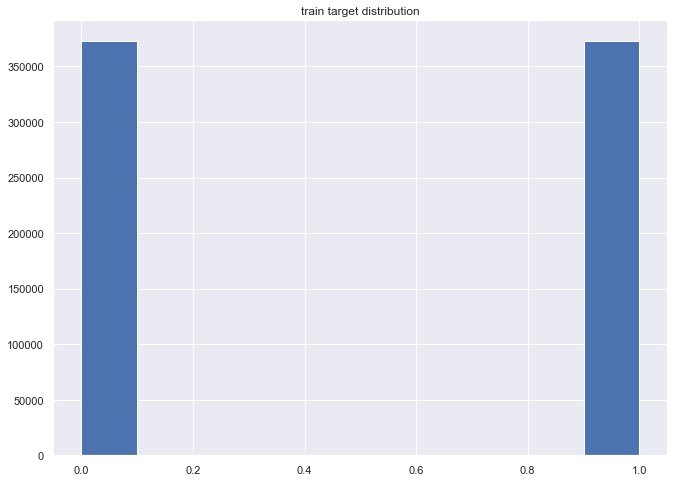

In [ ]:
plt.figure(figsize=(11, 8))
plt.title('train target distribution')
plt.hist(y_train_sm)
plt.show()

Обучимся с помощью [`lightgbm`](https://lightgbm.readthedocs.io/en/latest/) с байесовской оптимизацией гиперпараметров, и для каждой модели сделаем предсказание на тестовой выборке. Также будем сохранять важности признаков на каждом фолде.


In [ ]:
%%time


import warnings
warnings.filterwarnings("ignore")
from bayes_opt import BayesianOptimization

def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=4, random_seed=6, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    # parameters
    def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, lambda_l1,lambda_l2,early_stopping_round):
        params = {'application':'binary', 'metric':'auc'}
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['max_bin'] = int(round(max_depth))
        params['lambda_l1'] = int(round(lambda_l1))
        params['lambda_l2'] = int(round(lambda_l2))
        params['early_stopping_round'] = int(round(early_stopping_round))
        
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =250,num_boost_round=1500, metrics=['auc'])
        return max(cv_result['auc-mean'])
     
    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.04, 0.65),
                                            'num_leaves': (8, 240),
                                            'feature_fraction': (0.21, 0.9),
                                            'bagging_fraction': (0.2, 0.9),
                                            'max_depth': (4, 25),
                                            'max_bin':(5,65),
                                            'early_stopping_round' : (10,300),
                                            'lambda_l1': (0, 10),
                                            'lambda_l2':  (0, 10)}, random_state=200)                                   
                                      


    
    #n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
    #init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
    
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    model_auc=[]
    for model in range(len( lgbBO.res)):
        model_auc.append(lgbBO.res[model]['target'])
    
    # return best parameters
    return lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']

opt_params = bayes_parameter_opt_lgb(df_train.drop('isFraud', axis=1), df_train['isFraud'].values, init_round=5, opt_round=10, n_folds=4, random_seed=6)

In [ ]:
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params[1]['objective']='binary'
opt_params[1]['metric']='auc'
# opt_params[1]['is_unbalance']=True
#opt_params[1]['boost_from_average']=False
opt_params=opt_params[1]
opt_params

In [ ]:
%%time

import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=18)

params = {'bagging_fraction': 0.96,
 'early_stopping_round': 63,
 'feature_fraction': 0.57,
#  'lambda_l1': 0.0,
#  'lambda_l2': 10.0,
 'learning_rate': 0.011,
 'max_bin': 46,
 'max_depth': 25,
 'metric': 'auc',
 'num_leaves': 200,
 'objective': 'binary',
 'n_jobs': -1}

scores = []

# feature_importances = pd.DataFrame()
# feature_importances['feature'] = df_train.columns.drop('isFraud')

test_preds = []

for train_index, test_index in kf.split(df_tr_sm):
    X_train = df_tr_sm.drop('isFraud', axis=1).iloc[train_index]
    y_train = df_tr_sm['isFraud'].iloc[train_index].values
    X_val = df_tr_sm.drop('isFraud', axis=1).iloc[test_index]
    y_val = df_tr_sm['isFraud'].iloc[test_index].values


    # model = CatBoostClassifier(learning_rate=0.01, 
    #                            max_depth=10, 
    #                            n_estimators=2500, 
    #                            early_stopping_rounds=300, 
    #                            eval_metric="AUC", 
    #                            task_type='GPU', 
    #                            random_seed=13, 
    #                            logging_level='Silent'
    # )
    # model.fit(X_train, y_train)

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_eval, verbose_eval=250, num_boost_round=4000)
    
    # feature_importances['fold_{}'.format(i)] = lgb_model.feature_importance()

    y_pred = lgb_model.predict(X_val)
    score_fold = roc_auc_score(y_val, y_pred)
    scores.append(score_fold)
    y_test_pred = lgb_model.predict(df_test)
    test_preds.append(y_test_pred)

for i in range(len(scores)):
    print('Fold {}, AUC-ROC: {:.5f}'.format(i, scores[i]))
print('CV AUC-ROC: {:.5f}'.format(np.mean(scores)))

[LightGBM] [Info] Number of positive: 298530, number of negative: 297961
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.360182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16611
[LightGBM] [Info] Number of data points in the train set: 596491, number of used features: 429
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500477 -> initscore=0.001908
[LightGBM] [Info] Start training from score 0.001908
Training until validation scores don't improve for 63 rounds
[250]	valid_0's auc: 0.995812
[500]	valid_0's auc: 0.9977
[750]	valid_0's auc: 0.998315
[1000]	valid_0's auc: 0.998588
[1250]	valid_0's auc: 0.998734
[1500]	valid_0's auc: 0.998839
[1750]	valid_0's auc: 0.998894
[2000]	valid_0's auc: 0.998933
[2250]	valid_0's auc: 0.998964
[2500]	valid_0's auc: 0.998995
[2750]	valid_0's auc: 0.999018
[3000]	valid_0's auc: 0.999038
[3250]	v

Для получения итогового предсказания на тестовой выборке усредним предсказания моделей с разных фолдов.

In [ ]:
np.array(test_preds).shape

(4, 172981)

In [ ]:
final_pred = np.average(test_preds, axis=0)
final_pred

array([9.75266016e-05, 7.18107928e-03, 4.55382428e-03, ...,
       1.41414135e-03, 4.06154792e-03, 2.01037406e-03])

In [ ]:
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': final_pred})
sub.head()

,TransactionID,isFraud
0,3404559,0.000098
1,3404560,0.007181
2,3404561,0.004554
3,3404562,0.000779
4,3404563,0.186548


In [ ]:
sub.tail()

,TransactionID,isFraud
172976,3577535,0.000537
172977,3577536,0.006469
172978,3577537,0.004114
172979,3577538,0.006107
172980,3577539,0.003173


Сохраняем файл с предсказаниями - теперь его можно отправить в соревнование и посмотреть результат на публичной части.

In [ ]:
sub.to_csv('C:/Users/pavvv/Downloads/submission_baseline.csv', index=False)